In [1]:
!pip install kagglehub seaborn --quiet

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [2]:
# Descargar el dataset desde Kaggle
path = kagglehub.dataset_download("mosapabdelghany/medical-insurance-cost-dataset")
print("Ruta descargada:", path)

# Cargar el archivo principal del dataset
df = pd.read_csv(f"{path}/insurance.csv")
df.head()


100%|██████████| 16.0k/16.0k [00:00<00:00, 20.2MB/s]

Extracting files...
Ruta descargada: /root/.cache/kagglehub/datasets/mosapabdelghany/medical-insurance-cost-dataset/versions/1


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploración del conjunto de datos

En esta sección reviso la estructura básica del dataset de costos de seguro médico:
cuántas filas y columnas tiene, qué tipos de variables incluye y si hay valores faltantes.
Esto sirve para entender con qué datos voy a trabajar y qué limpieza es necesaria antes
de aplicar técnicas de regresión.


In [3]:
# Dimensiones del dataset
print("Shape (filas, columnas):", df.shape)

# Información general de tipos de datos
print("\nInformación del DataFrame:")
df.info()

# Descripción estadística de variables numéricas
print("\nDescripción estadística (numéricas):")
print(df.describe())

# Descripción estadística de variables categóricas
print("\nDescripción estadística (categóricas):")
print(df.describe(include="object"))

# Valores nulos por columna
print("\nValores nulos por columna:")
print(df.isna().sum())


Shape (filas, columnas): (1338, 7)

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Descripción estadística (numéricas):
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.

### Resumen de la exploración inicial

- El dataset tiene 1338 filas y 7 columnas, lo que es un tamaño pequeño-moderado para un ejercicio de regresión.
- Las variables numéricas son: `age`, `bmi`, `children`, `charges`.
- Las variables categóricas son: `sex`, `smoker`, `region`.
- No se observan valores nulos en ninguna columna, por lo que no es necesario imputar datos faltantes.
- Las estadísticas básicas muestran que:
  - La edad media ronda los 39 años.
  - El BMI medio está alrededor de 30, lo que indica que muchas personas están en rango de sobrepeso/obesidad.
  - La variable objetivo `charges` presenta una distribución muy dispersa, con una diferencia grande entre el mínimo y el máximo, lo que ya sugiere posibles outliers en los costos.


## Análisis univariante

Reviso la distribución de cada variable por separado para entender
cómo se comportan las edades, el IMC (BMI), el número de hijos,
los costos (`charges`) y las categorías como sexo, fumador y región.


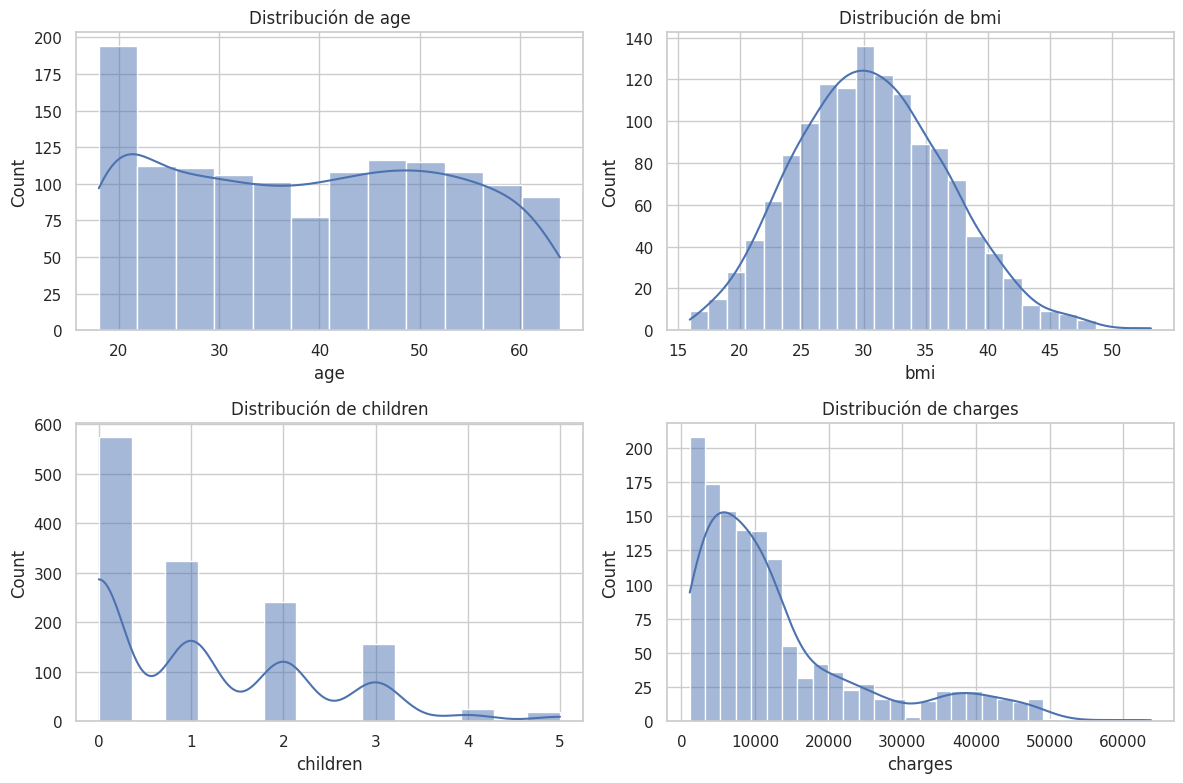

In [4]:
numeric_cols = ["age", "bmi", "children", "charges"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribución de {col}")
plt.tight_layout()
plt.show()


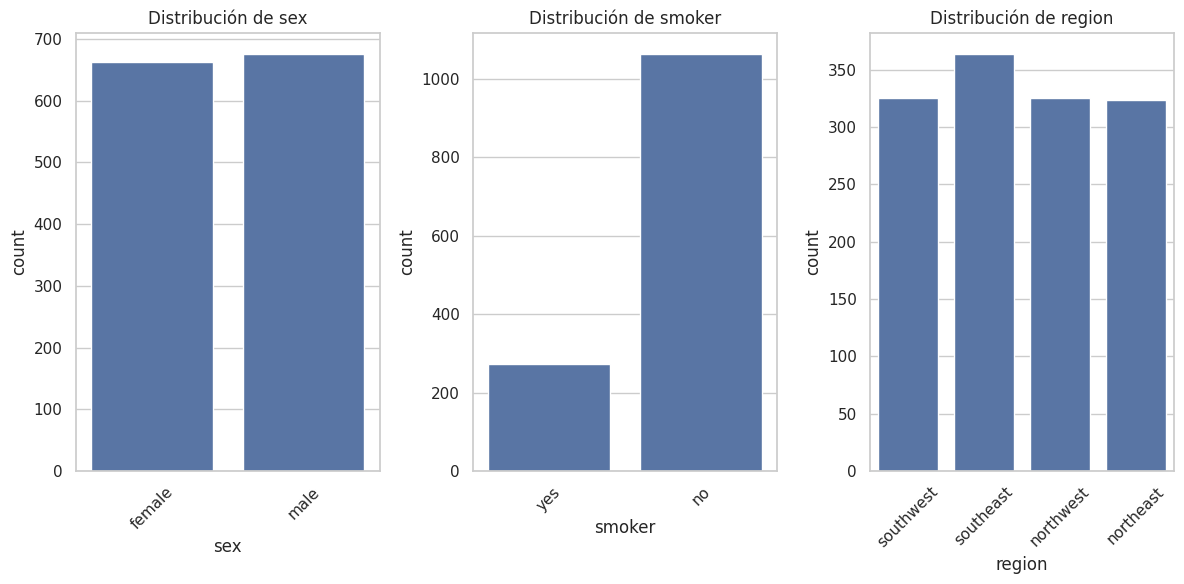

In [5]:
categorical_cols = ["sex", "smoker", "region"]

plt.figure(figsize=(12, 6))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df, x=col)
    plt.title(f"Distribución de {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Conclusiones del análisis univariante

- **Edad (`age`)**: La distribución es relativamente uniforme, pero se nota una ligera concentración en adultos jóvenes (20–30 años). Esto indica que la muestra no está dominada ni por niños ni por adultos mayores.
- **BMI (`bmi`)**: La mayoría de los valores están alrededor de 30, lo que sugiere una proporción alta de personas con sobrepeso u obesidad.
- **Hijos (`children`)**: Los valores se concentran en pocas cantidades de hijos (0–2). No hay muchos casos con muchos dependientes.
- **Costos (`charges`)**: La distribución está muy sesgada hacia la derecha, con muchos pacientes con costos relativamente bajos y unos pocos con costos extremadamente altos. Esto confirma la presencia de outliers en la variable objetivo.
- **Sexo (`sex`)**: La muestra está bastante balanceada entre hombres y mujeres.
- **Fumador (`smoker`)**: Hay muchos más no fumadores que fumadores. Esto es importante porque el grupo de fumadores será más pequeño, pero probablemente con costos más altos.
- **Región (`region`)**: Las cuatro regiones aparecen representadas, sin un desequilibrio extremo entre ellas.


## Filtrado de outliers

La variable objetivo `charges` tiene una distribución muy sesgada
y algunos valores extremadamente altos. Para evitar que estos pocos
casos dominen el ajuste del modelo de regresión, aplico un filtro
por intercuartiles (IQR).

La idea es:
- Calcular Q1 (25%) y Q3 (75%) de `charges`.
- Calcular IQR = Q3 - Q1.
- Eliminar registros con `charges` por debajo de Q1 - 1.5*IQR o por encima de Q3 + 1.5*IQR.

Este filtrado reduce el impacto de outliers extremos, manteniendo
la mayoría de los datos reales.


In [6]:
Q1 = df["charges"].quantile(0.25)
Q3 = df["charges"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Límite inferior:", lower_bound)
print("Límite superior:", upper_bound)

df_iqr = df[(df["charges"] >= lower_bound) & (df["charges"] <= upper_bound)]
print("Shape original:", df.shape)
print("Shape después de filtrar por IQR:", df_iqr.shape)


Límite inferior: -13109.1508975
Límite superior: 34489.350562499996
Shape original: (1338, 7)
Shape después de filtrar por IQR: (1199, 7)


## Tratamiento de la variable objetivo

La variable objetivo `charges` presenta una fuerte asimetría
(cola larga hacia valores altos). Para estabilizar la varianza
y reducir el impacto de los costos extremadamente altos,
creo una versión transformada usando logaritmo natural: `log_charges`.

Para el análisis exploratorio sigo usando `charges` porque es más
interpretables en dólares, pero para el modelo de regresión es
útil entrenar usando `log_charges` como objetivo.


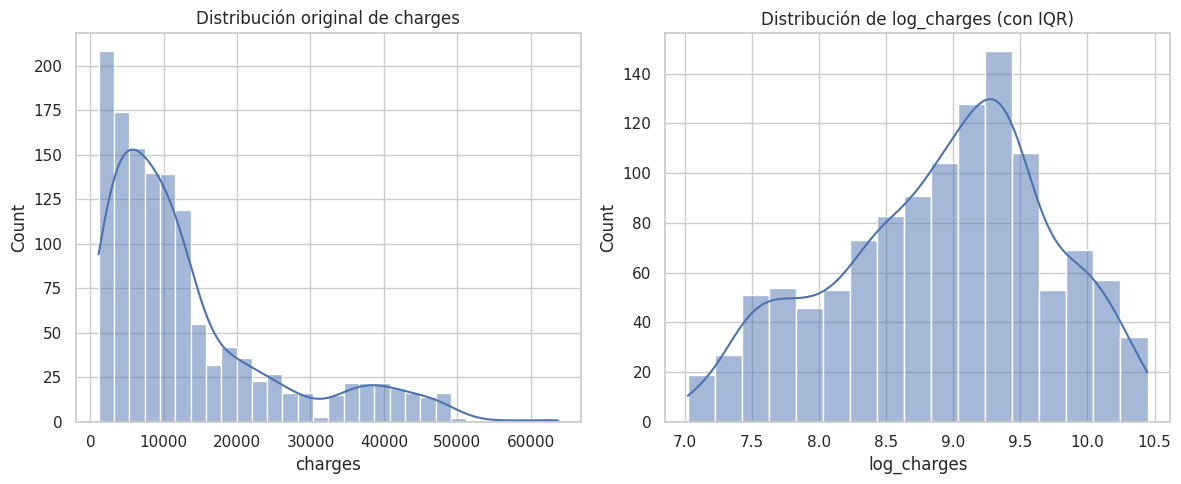

In [7]:
df_iqr = df_iqr.copy()  # por seguridad
df_iqr["log_charges"] = np.log1p(df_iqr["charges"])  # log(1 + charges)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df["charges"], kde=True)
plt.title("Distribución original de charges")

plt.subplot(1, 2, 2)
sns.histplot(df_iqr["log_charges"], kde=True)
plt.title("Distribución de log_charges (con IQR)")

plt.tight_layout()
plt.show()


## Análisis bivariante

Ahora analizo la relación entre la variable objetivo (`charges`)
y cada variable explicativa (edad, BMI, hijos, fumador, etc.).
Esto ayuda a entender qué factores parecen tener mayor impacto
en el costo del seguro.


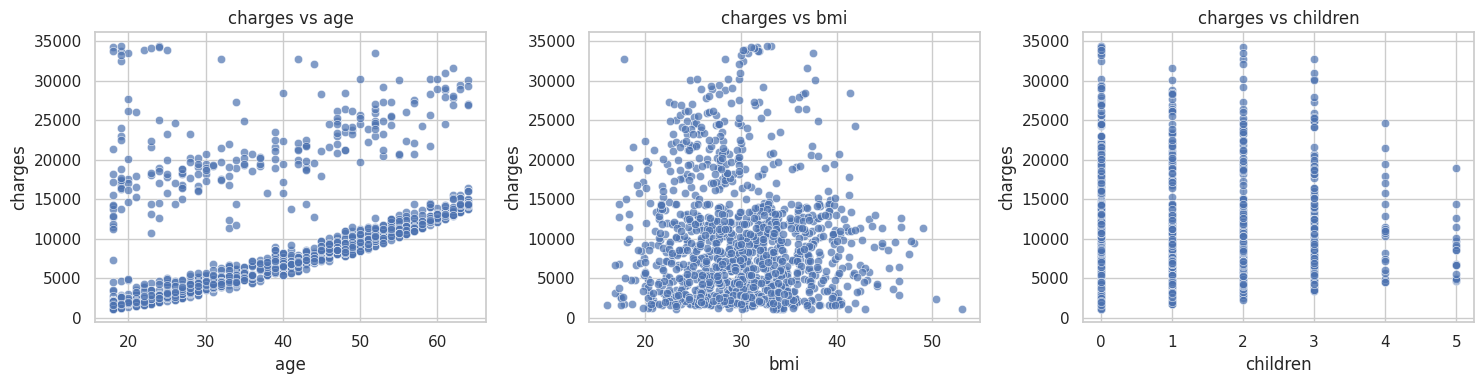

In [9]:
features_numeric = ["age", "bmi", "children"]

plt.figure(figsize=(15, 4))
for i, col in enumerate(features_numeric, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(data=df_iqr, x=col, y="charges", alpha=0.7)
    plt.title(f"charges vs {col}")
plt.tight_layout()
plt.show()


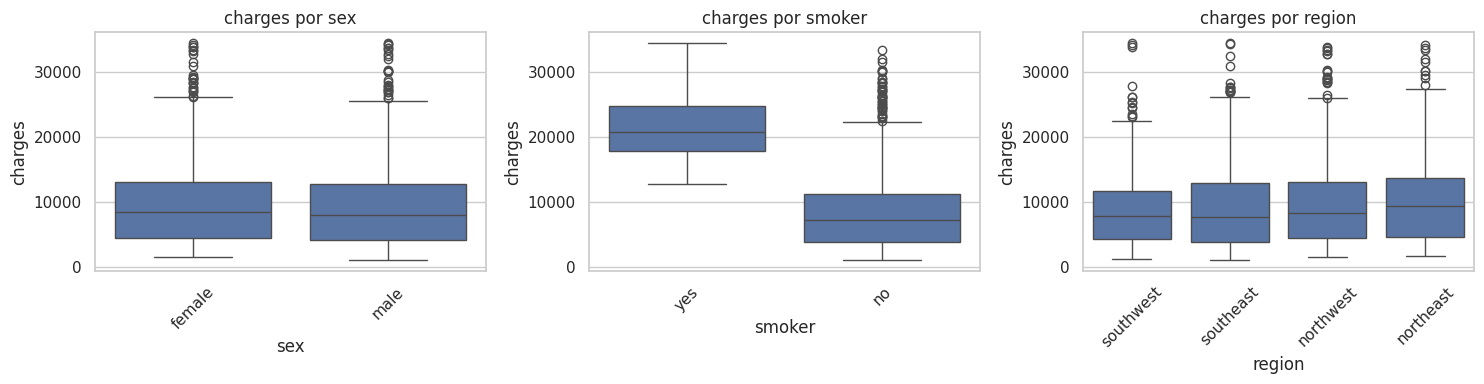

In [10]:
features_cat = ["sex", "smoker", "region"]

plt.figure(figsize=(15, 4))
for i, col in enumerate(features_cat, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df_iqr, x=col, y="charges")
    plt.title(f"charges por {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Conclusiones del análisis bivariante

- **Edad vs charges**: En general, a mayor edad se tiende a ver un incremento en los costos, aunque hay bastante dispersión. Esto indica que la edad sí influye, pero no es el único factor.
- **BMI vs charges**: Para valores de BMI más elevados se observan costos más altos en varios casos, especialmente cuando se combinan con otros factores de riesgo.
- **Hijos vs charges**: El número de hijos no muestra una relación tan fuerte con los costos. Puede influir ligeramente, pero no parece ser la variable principal.
- **Fumador (`smoker`)**: Es la variable que más destaca. Las personas fumadoras tienen, en promedio, costos de seguro muy superiores a los no fumadores.
- **Sexo (`sex`)**: No se aprecia una diferencia tan marcada entre hombres y mujeres en los costos.
- **Región (`region`)**: Las diferencias entre regiones existen, pero no parecen tan fuertes. Esto sugiere que la región podría no ser una variable clave para el modelo.


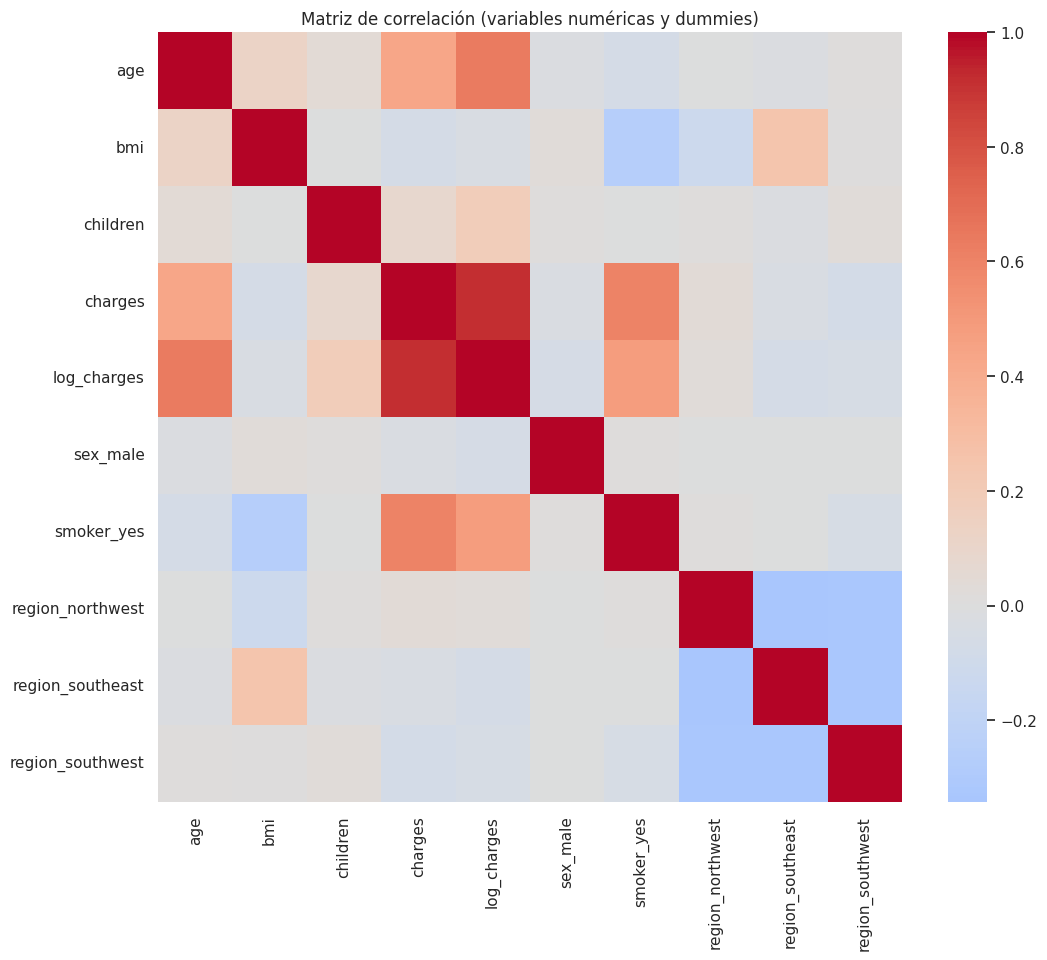

Correlaciones con 'charges':
charges             1.000000
log_charges         0.912699
smoker_yes          0.602220
age                 0.437642
children            0.083713
region_northwest    0.035171
sex_male           -0.024358
region_southeast   -0.028649
bmi                -0.066495
region_southwest   -0.070884
Name: charges, dtype: float64


In [11]:
# One-hot encoding de variables categóricas
df_encoded = pd.get_dummies(
    df_iqr,
    columns=["sex", "smoker", "region"],
    drop_first=True  # para evitar multicolinealidad perfecta
)

# Matriz de correlación
corr = df_encoded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Matriz de correlación (variables numéricas y dummies)")
plt.show()

# Ordenar correlaciones con la variable objetivo
corr_target = corr["charges"].sort_values(ascending=False)
print("Correlaciones con 'charges':")
print(corr_target)


### Interpretación de la matriz de correlación

- La variable con mayor correlación positiva con `charges` es `smoker_yes`, lo que confirma que fumar está fuertemente asociado a mayores costos.
- `bmi` y `age` también muestran correlaciones positivas moderadas con `charges`, indicando que el sobrepeso y la edad elevan el costo del seguro.
- El número de hijos (`children`) tiene una correlación baja.
- Las variables relacionadas con la región (`region_*`) tienen correlaciones muy cercanas a cero.
- El sexo (`sex_male`) tampoco muestra una relación fuerte con los costos.

Por criterio de negocio, tiene más sentido mantener:
- Edad, BMI, número de hijos y condición de fumador,
y considerar que **la región puede eliminarse** del modelo porque su aporte es bajo y añade complejidad sin mucho beneficio.


In [12]:
from sklearn.model_selection import train_test_split

# Creamos una columna de bins de charges para estratificar
df_split = df_iqr.copy()
df_split["charges_bin"] = pd.qcut(df_split["charges"], q=5, labels=False)

df_split["charges_bin"].value_counts(normalize=True).sort_index()


,proportion
charges_bin,
0,0.200167
1,0.200167
2,0.199333
3,0.200167
4,0.200167


In [13]:
train_df, test_df = train_test_split(
    df_split,
    test_size=0.2,
    random_state=42,
    stratify=df_split["charges_bin"]
)

# Quitamos la columna auxiliar
train_df = train_df.drop(columns=["charges_bin"])
test_df = test_df.drop(columns=["charges_bin"])

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (959, 8)
Test shape: (240, 8)


In [14]:
def resumen_bins(data, nombre):
    bins = pd.qcut(data["charges"], q=5, labels=False)
    print(f"\n{nombre}")
    print(bins.value_counts(normalize=True).sort_index())

resumen_bins(df_iqr, "Original (con IQR)")
resumen_bins(train_df, "Train")
resumen_bins(test_df, "Test")



Original (con IQR)
charges
0    0.200167
1    0.200167
2    0.199333
3    0.200167
4    0.200167
Name: proportion, dtype: float64

Train
charges
0    0.200209
1    0.200209
2    0.199166
3    0.200209
4    0.200209
Name: proportion, dtype: float64

Test
charges
0    0.2
1    0.2
2    0.2
3    0.2
4    0.2
Name: proportion, dtype: float64


### División train / test (80/20)

Dividí el dataset en:
- 80% para entrenamiento (`train_df`)
- 20% para prueba (`test_df`)

Para mantener una distribución similar de la variable objetivo en ambos conjuntos,
estratifiqué usando una versión binned de `charges` (rangos de costo). Esto ayuda
a que tanto train como test tengan proporciones parecidas de casos con costos bajos,
medios y altos, evitando que el modelo se entrene sólo con un tipo de paciente.


In [15]:
import os

os.makedirs("data", exist_ok=True)

train_df.to_csv("data/train_insurance.csv", index=False)
test_df.to_csv("data/test_insurance.csv", index=False)

print("Archivos guardados en la carpeta 'data':")
!ls data


Archivos guardados en la carpeta 'data':
test_insurance.csv  train_insurance.csv
